In [115]:
import random
from string import ascii_uppercase, ascii_letters
from pprint import pprint
from copy import deepcopy
import dill
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 27)
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mclr

In [222]:
## initial data needed to generate setup of rotors through Bombe Scrambler
# entry = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# raw_rotors = {'I': 'EKMFLGDQVZNTOWYHXUSPAIBRCJ', 'II': 'AJDKSIRUXBLHWTMCQGZNPYFVOE', 'III': 'BDFHJLCPRTXVZNYEIWGAKMUSQO', 'IV': 'ESOVPZJAYQUIRHXLNFTGKDCMWB', 'V': 'VZBRGITYUPSDNHLXAWMJQOFECK'}
# forward_rotors = {k:[ascii_uppercase.index(c) for c in raw_rotors[k]] for k in raw_rotors.keys()}
# rev_rotors = {}
# for r in raw_rotors.keys():
#     working = {k:entry.index(v) for k,v in zip(raw_rotors[r],entry)}
#     rev_rotors[r] = [working[k] for k in sorted(working.keys())]
# reflectors = {'Brf': {'A': 'Y', 'B': 'R', 'C': 'U', 'D': 'H', 'E': 'Q', 'F': 'S', 'G': 'L', 'H': 'D', 'I': 'P', 'J': 'X', 'K': 'N', 'L': 'G', 'M': 'O', 'N': 'K', 'O': 'M', 'P': 'I', 'Q': 'E', 'R': 'B', 'S': 'F', 'T': 'Z', 'U': 'C', 'V': 'W', 'W': 'V', 'X': 'J', 'Y': 'A', 'Z': 'T'}, 
#               'Crf': {'A': 'F', 'B': 'V', 'C': 'P', 'D': 'J', 'E': 'I', 'F': 'A', 'G': 'O', 'H': 'Y', 'I': 'E', 'J': 'D', 'K': 'R', 'L': 'Z', 'M': 'X', 'N': 'W', 'O': 'G', 'P': 'C', 'Q': 'T', 'R': 'K', 'S': 'U', 'T': 'Q', 'U': 'S', 'V': 'B', 'W': 'N', 'X': 'M', 'Y': 'H', 'Z': 'L'}}

entry = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
raw_rotors = {'I': 'EKMFLGDQVZNTOWYHXUSPAIBRCJ', 'II': 'AJDKSIRUXBLHWTMCQGZNPYFVOE', 'III': 'BDFHJLCPRTXVZNYEIWGAKMUSQO', 'IV': 'ESOVPZJAYQUIRHXLNFTGKDCMWB', 'V': 'VZBRGITYUPSDNHLXAWMJQOFECK'}
notches = {'I':'Q','II':'E','III':'V','IV':'J','V':'Z'}
## forward rotors is the forward in:out pairings of each rotor as the character index of the A-Z ascii alphabet stored in 'entry'
forward_rotors = {k:[ascii_uppercase.index(c) for c in raw_rotors[k]] for k in raw_rotors.keys()}

## couldn't see a straightforward list comprehension for the reverse - the in:out pairing for when the current flows
## back from the reflector to the final output. Hopefully this two-step for loop isn't too slow
rev_rotors = {}
for r in raw_rotors.keys():
    working = {k:entry.index(v) for k,v in zip(raw_rotors[r],entry)}
    rev_rotors[r] = [working[k] for k in sorted(working.keys())]

# for k,v in rev_rotors.items():
#     print(k,':',v)

## in:out pairings for reflectors are hardcoded in, were originally generated by code
reflectors = {'B': {'A': 'Y', 'B': 'R', 'C': 'U', 'D': 'H', 'E': 'Q', 'F': 'S', 'G': 'L', 'H': 'D', 'I': 'P', 'J': 'X', 'K': 'N', 'L': 'G', 'M': 'O', 'N': 'K', 'O': 'M', 'P': 'I', 'Q': 'E', 'R': 'B', 'S': 'F', 'T': 'Z', 'U': 'C', 'V': 'W', 'W': 'V', 'X': 'J', 'Y': 'A', 'Z': 'T'}, 'C': {'A': 'F', 'B': 'V', 'C': 'P', 'D': 'J', 'E': 'I', 'F': 'A', 'G': 'O', 'H': 'Y', 'I': 'E', 'J': 'D', 'K': 'R', 'L': 'Z', 'M': 'X', 'N': 'W', 'O': 'G', 'P': 'C', 'Q': 'T', 'R': 'K', 'S': 'U', 'T': 'Q', 'U': 'S', 'V': 'B', 'W': 'N', 'X': 'M', 'Y': 'H', 'Z': 'L'}}
# print(reflectors)
blank_status = {char:0 for char in entry}
iomap = {'in':'I', 'out':'O', 'conx_in':'I', 'conx_out':'O'}
invsoutmap = {'in':'O','out':'I'}
grey = mclr.to_rgba('gainsboro',0.2)
red = mclr.to_rgba('firebrick',0.9)
orange = mclr.to_rgba('lightsalmon',0.8)
transparent = mclr.to_rgba('white',alpha=0)

## First create object class for a single scrambler
<br>One scrambler is a set of 3 enigma rotors and a reflector, through which signal passes once forwards, round the reflector then once back through the 3 rotors again, spitting out the cypher letter for a given input letter.

In [3]:
class ScramblerBombe:
    
    def __init__(self,left_rotor,middle_rotor,right_rotor,reflector,menu_link='ZZZ',conx_in={},conx_out={}):
        """rotors must be strings referring to either ['I','II','III','IV','V']
        reflector must be string, one of either ['B','C']"""
        
        self.right_rotor = right_rotor
        self.middle_rotor = middle_rotor
        self.left_rotor = left_rotor
        self.reflector = reflectors[reflector]
        self.menu_link = menu_link
        self.middle_notch = entry.index(notches[self.middle_rotor])   ## point if right rotor reaches will trigger middle rotor to step
        self.left_notch = entry.index(notches[self.left_rotor])  ## point if middle rotor reaches will trigger left rotor to step
        self.current_position = menu_link
        self.pos_left_rotor, self.pos_mid_rotor, self.pos_rgt_rotor = (ascii_uppercase.index(m) for m in menu_link.upper())
        self.status = {}
        self.status['in'] = {char:0 for char in entry}
        self.status['out'] = {char:0 for char in entry}
        self.conx_in = conx_in
        self.conx_out = conx_out
        
    def once_thru_scramble(self,start_character, direction, first_rotor, pos1, second_rotor, pos2, 
                       third_rotor, pos3):
        """ start_character must be single ASCII character A-Z
        direction is either 'forward' or 'back' """
        if direction == 'forward':
            usedict = {k:v for k,v in forward_rotors.items()}
        elif direction == 'back':
            usedict = {k:v for k,v in rev_rotors.items()}
        else:
            print('only forward or back for direction')
            return 'wtf'

        start_character = start_character.upper()
        entry_pos = entry.index(start_character)
        fst_pos_modifier = (26 + pos1 - 0)%26
        fst_in = (entry_pos + fst_pos_modifier)%26
        fst_out = usedict[first_rotor][fst_in]
        ch1o = entry[fst_out]

        scd_pos_modifier = (26 + pos2 - pos1)%26
        scd_in = (fst_out + scd_pos_modifier)%26
        ch2i = entry[scd_in]
        scd_out = usedict[second_rotor][scd_in]
        ch2o = entry[scd_out]

        thd_pos_modifier = (26 + pos3 - pos2)%26
        thd_in = (scd_out + thd_pos_modifier)%26
        ch3i = entry[thd_in]
        thd_out = usedict[third_rotor][thd_in]
        ch3o = entry[thd_out]

#         if direction == 'forward':
#             print(f"{start_character} -> (RR out) {ch1o} -> (MR in) {ch2i} -> (MR out) {ch2o} -> (LR in) {ch3i} -> (LR out) {ch3o}")
#         elif direction == 'back':
#             print(f"{start_character} -> (LR out) {ch1o} -> (MR in) {ch2i} -> (MR out) {ch2o} -> (RR in) {ch3i} -> (RR out) {ch3o}")

        return ch3o
    
    def full_scramble(self,in_ch):
        in_ch = in_ch.upper()
        left_rotor = self.left_rotor
        middle_rotor = self.middle_rotor
        right_rotor = self.right_rotor
        rflector = self.reflector
        ## first run right to left through scrambler
        forward_run = self.once_thru_scramble(in_ch, direction='forward', first_rotor=right_rotor, pos1=self.pos_rgt_rotor, 
                                              second_rotor=middle_rotor, pos2=self.pos_mid_rotor, 
                                              third_rotor=left_rotor, pos3=self.pos_left_rotor)

        ## reflector back around for return
        rfi_pos_mod = (26 + 0 - self.pos_left_rotor)%26    ## the '0' is there to matching formatting of other position modifiers - reflector is not moved so it will always be 0
        rf_in = (entry.index(forward_run) + rfi_pos_mod)%26
        chri = entry[rf_in]
        mirrored = rflector[chri]

#         print(f"{forward_run} -> {chri} (into reflector) -> {mirrored} (reflected out)")

        ## second run back left to right thru scrambler
        back_run = self.once_thru_scramble(mirrored, direction='back', first_rotor=left_rotor, pos1=self.pos_left_rotor, 
                                      second_rotor=middle_rotor, pos2=self.pos_mid_rotor, third_rotor=right_rotor, pos3=self.pos_rgt_rotor)

        bk_out = entry.index(back_run)
        bko_pos_mod = (26 + 0 - self.pos_rgt_rotor)%26  ## as above, '0' just reflects that the entry interface doesn't move
        bk_final = (bk_out + bko_pos_mod)%26
        final = entry[bk_final]
#         print('RR back out:  ', back_run, '-->', final)
#         print(in_ch,"-->",final)
        return final
    
    def rotor_step(self,rotor_position):
        """To be used on any single rotor. Steps forward one position, resetting back to 0 after it reaches 25"""
        if rotor_position == 25:
            rotor_position = 0
        else:
            rotor_position += 1
        return rotor_position
    
    def translate_current_position(self):
        """Reads the numerical position of each of the 3 rotors, and translates into ZZA-style alphabet position
        That is, for each of the three rotors, it's numerical position from 0-25 is mapped to the letter of the 
        alphabet this corresponds to. Note that this is purely for displaying the setting to the user, it can't 
        do anything to alter the actual rotor position, which is stored as the numerical variable"""
        self.current_position = ''
        for pos in self.pos_left_rotor,self.pos_mid_rotor,self.pos_rgt_rotor:
            self.current_position += entry[pos]
    
    def step_enigma(self):
        """Just acts on itself, steps all three rotors, stepping either 1,2 or 3 rotors based on the 
        notch position"""
#         print(f"Lpos={self.pos_left_rotor}, Mpos={self.pos_mid_rotor}, Rpos={self.pos_rgt_rotor}")
        if self.pos_rgt_rotor == self.middle_notch and self.pos_mid_rotor == self.left_notch:
            self.pos_rgt_rotor = self.rotor_step(self.pos_rgt_rotor)
            self.pos_mid_rotor = self.rotor_step(self.pos_mid_rotor)
            self.pos_left_rotor = self.rotor_step(self.pos_left_rotor)
#             print('--- left & middle rotor step')
        elif self.pos_rgt_rotor == self.middle_notch:
            self.pos_rgt_rotor = self.rotor_step(self.pos_rgt_rotor)
            self.pos_mid_rotor = self.rotor_step(self.pos_mid_rotor)
#             print('--- middle rotor step ---')
        else:
            self.pos_rgt_rotor = self.rotor_step(self.pos_rgt_rotor)
        
        self.translate_current_position()           
#         print(f"Lpos={self.pos_left_rotor}, Mpos={self.pos_mid_rotor}, Rpos={self.pos_rgt_rotor}")

    def update(self):
        """idea here is that the scrambler will check each of the 26 connections to see if they
        are live, and if so pass it through itself to live up the connection on the other side of 
        the scrambler"""
        for sides in [['in','out'],['out','in']]:
            for char, io in self.status[sides[0]].items():
                if io == 0:
                    pass
                else:
                    self.status[sides[1]][self.full_scramble(char)] = 1
                    
    def reset_status(self):
        """As it says on box, resets the status (dictionary of A-Z and 1/0 for each) all back to 0"""
        self.status['in'] = {char:0 for char in entry}
        self.status['out'] = {char:0 for char in entry}
        



In [4]:
# eb1 = ScramblerBombe(left_rotor='II',middle_rotor='V',right_rotor='III',reflector='C',menu_link='BCD')

## Now create object class for entire Bombe machine, which is made up of many sets of scramblers. 
<br>The actual Bletchley Park Bombes mostly had 3 rows of 12 scrambler sets each. As it is coded at the moment, this Python Bombe can actually be 'built' with any number of scrambler sets, depending on the 'menu' of scrambler interconnections and positions it is fed on initialisation.
<br>
The functions of the Bombe are about passing the 'live' connection from a single letter on the test register, through the scramblers as defined by their interconnections and current settings. A key variable that is constantly being checked and updated is the 'status' of each scrambler, which is a dictionary of every alphabet letter and whether it is on or off. It simulates the transmission of electricity through the physical machine by looping through functions which essentially switch statuses from off (0) to on (1) based on a set of rules for each function. 

In [305]:
class Bombe:
    
    def __init__(self,menu,left_rotor='I',middle_rotor='II',right_rotor='III',reflector='B'):
        """Needs to be initialised with a menu, which is a dictionary with a specific format of instructions
        for how scramblers are to be interconnected, and their starting positions"""
        self.left_rotor = left_rotor
        self.middle_rotor = middle_rotor
        self.right_rotor = right_rotor
        self.reflector = reflector
        self.scramblers = {}
        self.register = {'status':{char:0 for char in entry}}
        self.current_sum = sum(self.register['status'].values())
        self.run_record = {}

        self.menu = menu
        for key,val in self.menu.items():
            if key == 'config':
                self.test_char = self.menu['config']['test_char']
                self.register['conxns'] = self.menu['config']['conx_in']
            else:
                self.scramblers[key] = ScramblerBombe(self.left_rotor,self.middle_rotor,self.right_rotor,self.reflector,
                                                      menu_link=val['menu_link'],conx_in=val['conx_in'], conx_out=val['conx_out'])
        self.lowest_scrambler_order = min([key for key in self.scramblers.keys()])
        self.identity_scrambler = self.scramblers[self.lowest_scrambler_order]
        ### identity scrambler is just the first one in the sequence of letters used from the crib.
        ### will probably be 0/ZZZ unless that particular letter pair from the crib/cypher has not been
        ### used in the menu
    
    #######   HAVE A GOOD LOOK HERE AT WHAT PULSE CONNECTIONS IS DOING!!!   #######
    #######        >>>>>>>>>>>>                <<<<<<<<<<<<<<<
    
    def pulse_connections(self):
        """Goes through every scrambler (once only), and updates in and out terminals with live feeds via conx_in and
        conx_out from its connected scramblers. Should be run iteratively to exhaustion."""
        for order,scr in self.scramblers.items():
            ## i.e for each scrambler in the enigma, we're going to loop through it's conx_in and conx_out dict
            ## and check its connected scramblers to match any live wires
            for pos,side in scr.conx_in.items():
                ## for this scrambler, go through the conx_in dict. It has the other scrambler you need to 
                ## look at (pos, or the number/position label) and whether you're looking at the 'in' or 'out' side
                for ch,io in self.scramblers[pos].status[side].items():
                    # look through the scrambler's status for that side (in or out)
                    if io == 1:   # and if it has a live wire
                        scr.status[side][ch] = 1 # set the corresponding character in the conx_in dict of the 
                                                  # original scrambler being checked to also be live

            for pos,side in scr.conx_out.items():   ## repeating as above for conx_out
                for ch,io in self.scramblers[pos].status[side].items():
                    if io == 1:
                        scr.status[side][ch] = 1

                
    def sync_test_register(self):
        """similar to pulse_connections in that it updates terminals of scramblers, but is solely about the
        interconnections between the test register and those scramblers which are connected to it"""
        for pos,side in self.register['conxns'].items():
            ## for each of the scrambler terminals connected to the test register
            for ch,io in self.scramblers[pos].status[side].items():
                ## first sync any live wires from the scrambler to the test register
                if io == 1:   
                    self.register['status'][ch] = 1
            for ch,io in self.register['status'].items():
                ## but then also sync any live wires from the test register to the scrambler
                if io == 1:
                    self.scramblers[pos].status[side][ch] = 1           

    
    def light_character(self,in_character):
        """just need a way to put in the initial character input into all of the scramblers"""
        self.register['status'][self.test_char] = 1
    
    def update_all(self):
        """For every scrambler, runs update() which passes live terminals through the scrambler - from in to out
        and vice versa, for whatever the current position is"""
        for scr in self.scramblers.keys():
            self.scramblers[scr].update()
            
    def spin_scramblers(self):
        """Runs step_enigma for all scramblers, spinning the right rotor once and perhaps the middle and left if
        they are in their notch positions"""
        for scr in self.scramblers.values():
            scr.step_enigma()
            
    def reset_scramblers_and_register(self):
        """ resets all scrambler statuses and test register to 0 for all alphabet characters"""
        for scr in self.scramblers.values():
            scr.reset_status()
        self.register['status'] = {char:0 for char in entry}
    
    def check_this_lineup(self):
        """For running to exhaustion on a particular bombe scrambler lineup. 
        Loops through pulsing connections between scramblers and syncing back to the test register
        until the sum of live connections at the test register remains unchanged for two successive loops."""
        self.reset_scramblers_and_register()   # first make sure all scrambler inputs/outputs (statuses) are reset to zero
        self.light_character(self.test_char)   # light up the one test character
        self.sync_test_register()              # do the first syncing of test register, sending the signal out to the 
                                                # scramblers which are connected to the test register
            
    ### initialise the three sum variables (current_sum, previous_sum and olderer_sum) to keep track of whether 
    ### the sum of live connections have remained unchanged
#         print(self.register['status'])
        self.current_sum = sum(self.register['status'].values())
#         print(self.current_sum)
        olderer_sum = 0
        previous_sum = 0
        self.lineup_iters = 0   # this is just to keep track of how many iterations it took to reach a steady status
        while not (self.current_sum == previous_sum == olderer_sum):
#             print(f"BEFORE  olderer:{olderer_sum}    prev: {previous_sum}     curr: {self.current_sum}")
            olderer_sum = previous_sum
            previous_sum = self.current_sum
            self.update_all()
            self.pulse_connections()
            self.sync_test_register()
#             print([k for k,v in self.register['status'].items() if v == 1])
            self.current_sum = sum(self.register['status'].values())
#             print(f"AFTER   olderer:{olderer_sum}    prev: {previous_sum}     curr: {self.current_sum}")
            self.lineup_iters += 1
    
    def step_and_test(self):
        """the main function to use for looping through all possible combinations of rotor positions, 
        testing the connections at each step using check_this_lineup()"""
        self.spin_scramblers()
        self.check_this_lineup()
        self.run_record[self.identity_scrambler.current_position] = (self.current_sum,self.lineup_iters)
        if self.current_sum != 26:
            print('drop')
            print(self.identity_scrambler.current_position)
            

    def pdf_scrambler_statuses(self):
        """pdf = pandas dataframe
        Refreshes self.flash_scrambler_statuses variable to be a pandas dataframe summarising
        the current status (in==on/out==on) for each 26 alphabet letters for each of the scramblers in the Bombe"""
        bigdict = {}
        bigdict['REG'] = {k:('X' if v==1 else '') for k,v in self.register['status'].items()}
        for pos,scr in self.scramblers.items():
            littledict = {k:{l:(k[0].upper() if r == 1 else '') for l,r in v.items()} for k,v in scr.status.items()}
            bigdict[pos] ={k1:v1+littledict['out'][k1] for k1,v1 in littledict['in'].items()}
        self.flash_scrambler_statuses = pd.DataFrame(bigdict).T
        
    def nx_setup(self,scale=1,figsize=(15,10),width_of_bombe=0.1,height_of_bombe=0.06):
        """For creating NetworkX graphs. Setting up base graph (BG), detailed graph (TG), figure and axes for displaying scrambler connections
        Will also effectively reset the nx Graphs"""
        self.BG = nx.Graph()
        bombes = [k  if type(k) == int else 'REG' for k in menu.keys()]
        self.BG.add_nodes_from(bombes)
        
        base_edges = set()
        for scr_id,descriptor_dict in self.menu.items():
            if scr_id == 'config':
                scr_id = 'REG'
            for inorout in ['conx_in','conx_out']:
                for connected_scrambler,ior in descriptor_dict[inorout].items():  
                    ## the dictionary of connections that is the value for each 'conx_in/out' keys
                    base_edges.add(frozenset([scr_id,connected_scrambler])) # set of sets so not to double up

        base_edges = [tuple(be) for be in base_edges]  # turn set of frozensets into list of tuples
        self.BG.add_edges_from(base_edges)
#         self.base_pos_for_nx = nx.circular_layout(self.BG,scale=scale)
        self.base_pos_for_nx = nx.spring_layout(self.BG,scale=scale)
        self.base_pos_for_nx['REG'] = np.array([0,-0.9])
        
        ## This section for the detailed graph (TG) 
        self.TG = nx.Graph()
        ## this for-loop adds all nodes to the graph
        for bid in bombes:           ## for each scrambler in the menu
            for ch in entry:         ## for each letter A-Z
                for i in ['I','O']:  ## for each end (in/out) of the double-ended scrambler
                    if bid == 'REG': ## i = X (not I or O) if it's the register
                        i = 'X'
                    this_node_label = f"{bid}-{i}-{ch}"
                    self.TG.add_node(this_node_label)  ## add a node to the graph
                    self.TG.nodes[this_node_label]["color"] = grey
        
        ## this for-loop adds edges for scrambler connections to the graph
        self.inter_scr_edges = set()
        for scr_id,specs in self.menu.items():                       # for each scrambler (scr_id) and its spec dict
            for inorout in ['conx_in','conx_out']:                          # go thru the conx_in and conx_out dicts
                if scr_id == 'config':   # this just for dealing with the register
                    first_node = 'REG-X-'
                else:
                    first_node = f"{scr_id}-{iomap[inorout]}-"           # label the start of the 1st node, with either I/O
                for connected_scrambler,ior in specs[inorout].items():          # go thru the in/out connections
                    second_node = f"{connected_scrambler}-{iomap[ior]}-"        # label the start of the 2nd node
                    for ch in entry:                                                    # for each letter A-Z
                        self.inter_scr_edges.add(frozenset([first_node+ch,second_node+ch])) # create 26 nodes with each of 1st/2nd node plus letter
        
        self.intra_scr_edges = set()
#         for scr_id,specs in self.menu.items():
#             if scr_id == 'config':
#                 pass
#             else:
#                 instring = f"{scr_id}-I-"
#                 outstring = f"{scr_id}-O-"
#                 for i in range(26):
#                     thisstring = instring + entry[i]
#                     for ch in entry[i+1:]:
#                         self.intra_scr_edges.add(frozenset([thisstring,outstring+str(ch)]))
        
        ## bit of data reformatting for the edges
        self.inter_scr_edges = [list(fs) for fs in self.inter_scr_edges]
        self.intra_scr_edges = [list(fs) for fs in self.intra_scr_edges]
        for edge in self.inter_scr_edges:
            edge.append({'color': grey})
        for edge in self.intra_scr_edges:
            edge.append({'color': transparent})
        self.inter_scr_edges = [tuple(fs) for fs in self.inter_scr_edges]
        self.intra_scr_edges = [tuple(fs) for fs in self.intra_scr_edges]
        self.TG.add_edges_from(self.inter_scr_edges)
        self.TG.add_edges_from(self.intra_scr_edges)
        
        wrange_of_letters = list(np.linspace(-0.5*width_of_bombe,0.5*width_of_bombe,26))

        self.manual_pos = {}

        for node in self.TG.nodes():
            bid,io,ch = node.split('-')
            try:
                bid = int(bid)
            except:
                pass
            x,y = self.base_pos_for_nx[bid]

            if io == 'I':                       ## spacing apart the in from the out nodes
                y += -0.5 * height_of_bombe     ## 'in' (I) is below
            else:
                y += 0.5 * height_of_bombe      ## 'out' (O) is above

            x += wrange_of_letters[entry.index(ch)]
            self.manual_pos[node] = np.array([x,y])
            
        self.colors = [self.TG[u][v]['color'] for u,v in self.TG.edges()]
        
        fig, ax = plt.subplots(figsize=figsize)
        nx.draw_networkx_nodes(self.BG,pos=self.base_pos_for_nx)
        nx.draw_networkx_labels(self.BG,pos=self.base_pos_for_nx)
        nx.draw_networkx_edges(self.TG,pos=self.manual_pos,edge_color=self.colors)
        
    def graph_nx(self,figsize=(15,10),node_size=3):
        """First updates nx_graph edge colors based on current scrambler statuses,
        then redraws nx_graph visualisation"""
        for u,v in self.TG.edges():   ## reset previously red to orange
            if self.TG[u][v]['color'] == red:
                self.TG[u][v]['color'] = orange
        for u,v in self.TG.nodes.items():
            if self.TG.nodes[u]['color'] == red:
                self.TG.nodes[u]['color'] = orange
            
                
        for scr_id, scrambler in self.scramblers.items():
            for ior in ['in','out']:
                for ch, onoff in scrambler.status[ior].items():
                    if onoff == 1:
                        first_live_node = f"{scr_id}-{iomap[ior]}-{ch}"
                        if self.TG.nodes[first_live_node]['color'] == grey:
                            self.TG.nodes[first_live_node]['color'] = red
                        cypher_node = f"{scr_id}-{invsoutmap[ior]}-{scrambler.full_scramble(ch)}"
                        if (first_live_node,cypher_node) not in self.TG.edges():
                            self.TG.add_edge(first_live_node, cypher_node, color=red)
                        
                        if ior == 'in':
                            for bid, inout in scrambler.conx_in.items():
                                second_live_node = f"{bid}-{iomap[inout]}-{ch}"
                                try:
                                    if self.TG.edges[(first_live_node, second_live_node)]['color'] == grey:
                                        self.TG.edges[(first_live_node, second_live_node)]['color'] = red
                                except:
                                    if self.TG.edges[(second_live_node, first_live_node)]['color'] == grey:
                                        self.TG.edges[(second_live_node, first_live_node)]['color'] = red

                        elif ior == 'out':
                            for bid, inout in scrambler.conx_out.items():
                                second_live_node = f"{bid}-{iomap[inout]}-{ch}"
                                try:
                                    if self.TG.edges[(first_live_node, second_live_node)]['color'] == grey:
                                        self.TG.edges[(first_live_node, second_live_node)]['color'] = red
                                except:
                                    if self.TG.edges[(second_live_node, first_live_node)]['color'] == grey:
                                        self.TG.edges[(second_live_node, first_live_node)]['color'] = red

        for ch, onoff in self.register['status'].items():
            if onoff == 1:
                first_live_node = f"REG-X-{ch}"
                for bid,inout in self.register['conxns'].items():
                    second_live_node = f"{bid}-{iomap[inout]}-{ch}"
                    try:
                        if self.TG.edges[(first_live_node, second_live_node)]['color'] == grey:
                            self.TG.edges[(first_live_node, second_live_node)]['color'] = red
                    except:
                        if self.TG.edges[(second_live_node, first_live_node)]['color'] == grey:
                            self.TG.edges[(second_live_node, first_live_node)]['color'] = red
                        
        self.edge_colours = [self.TG[u][v]['color'] for u,v in self.TG.edges()]
        self.node_colours = [v['color'] for u,v in self.TG.nodes.items()]
        fig, ax = plt.subplots(figsize=figsize)
        nx.draw_networkx_nodes(self.BG,pos=self.base_pos_for_nx)
        nx.draw_networkx_labels(self.BG,pos=self.base_pos_for_nx)
        nx.draw_networkx_edges(self.TG,pos=self.manual_pos,edge_color=self.edge_colours)
        if node_size > 0:
            nx.draw_networkx_nodes(self.TG,pos=self.manual_pos,node_size=node_size,node_color=self.node_colours)

In [306]:
with open('menu_transfer.pickle', 'rb') as infile:
    menu = dill.load(infile)
# menu

In [339]:
tb1 = Bombe(menu,'I','II','III','B')
try:
    del(scr)
except:
    pass

In [340]:
# # %%time
while tb1.identity_scrambler.current_position != 'NPF':
    tb1.spin_scramblers()
print(tb1.identity_scrambler.current_position)

NPF


In [341]:
tb1.test_char #= 'C'

'E'

In [342]:
tb1.spin_scramblers()
tb1.reset_scramblers_and_register()
print(tb1.identity_scrambler.current_position)
tb1.light_character(tb1.test_char)
# tb1.sync_test_register()
# tb1.nx_setup()

NPG


In [343]:
myseed = 6615
## 6608 for menu based on opcode GLS and 9 scramblers
# 6615 or 6633 interesting for GLS 5 scr menu

6616


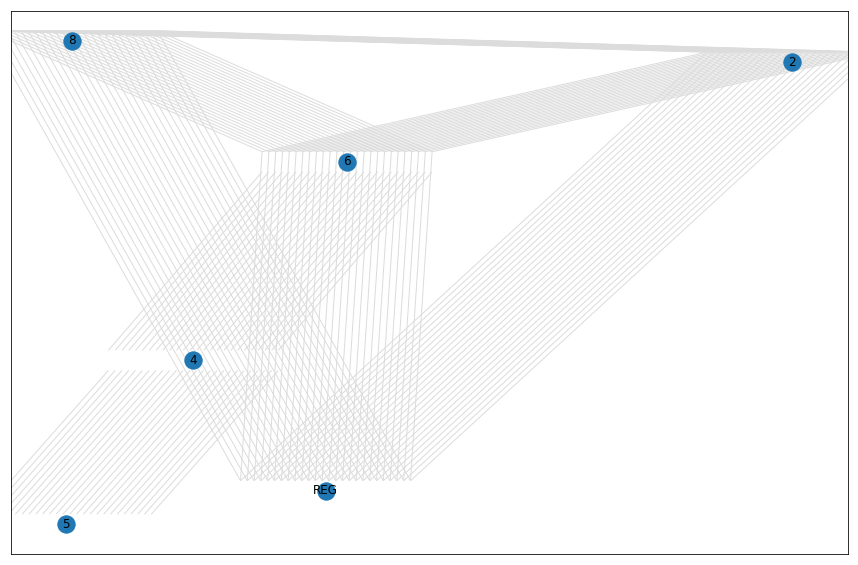

In [344]:
myseed += 1
np.random.seed(myseed)
print(myseed)
tb1.nx_setup()

In [345]:
# fig,ax = plt.subplots(figsize=(12,8))
# nx.draw_networkx(tb1.BG, pos=tb1.base_pos_for_nx)
# plt.savefig(f'./images/enigma_network_basic_node_edge_s{myseed}.png')

In [334]:
exple=0

# I think there is something wrong with the pulse connections function. Letters of scramblers that are not connected to anything are getting lit up (e.g. see scr 4 & 5 below)

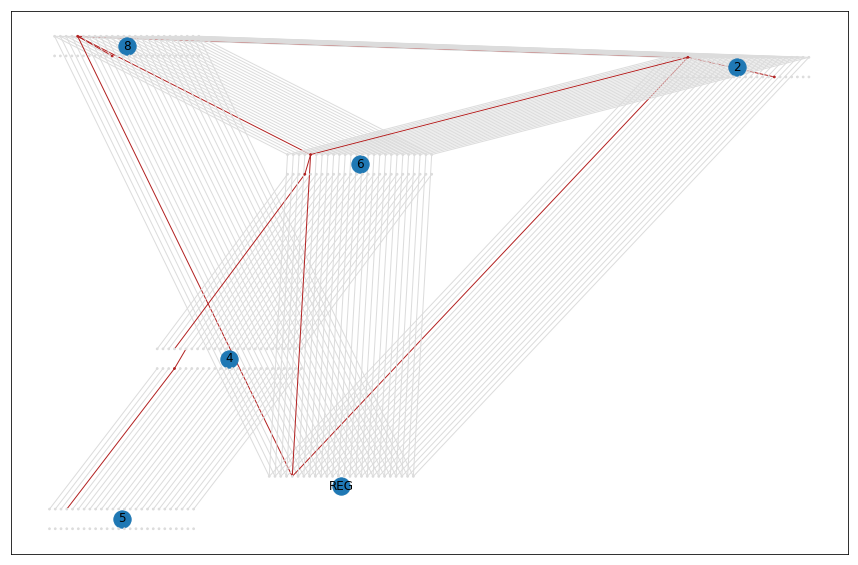

In [347]:
exple += 1  # this just for counting when exporting images
tb1.sync_test_register()
tb1.update_all()
tb1.pulse_connections()
tb1.graph_nx(figsize=(15,10),node_size=3)
# plt.savefig(f'./images/enigma_network_livewires_{exple}_s{myseed}.png')

In [348]:
tb1.pdf_scrambler_statuses()
tb1.flash_scrambler_statuses

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z
REG,,,,,X,,,,,,,,,,,,,,,,,,,,,
8,,,,,O,,,,,,I,,,,,,,,,,,,,,,
2,,,,,O,,,,,,,,,,,,,,,I,,,,,,
5,,,,,,,,,,,,,,,,,,,,,,,,,,
4,,,,I,,,,,,,,,,,,,,,,,,,,,,
6,,,,I,O,,,,,,,,,,,,,,,,,,,,,


In [337]:
tb1.menu

{8: {'in': 'Z',
  'out': 'E',
  'menu_link': 'ZZH',
  'conx_in': {},
  'conx_out': {2: 'out', 6: 'out'}},
 2: {'in': 'W',
  'out': 'E',
  'menu_link': 'ZZB',
  'conx_in': {},
  'conx_out': {8: 'out', 6: 'out'}},
 5: {'in': 'V',
  'out': 'T',
  'menu_link': 'ZZE',
  'conx_in': {},
  'conx_out': {4: 'in'}},
 4: {'in': 'T',
  'out': 'A',
  'menu_link': 'ZZD',
  'conx_in': {5: 'out'},
  'conx_out': {6: 'in'}},
 6: {'in': 'A',
  'out': 'E',
  'menu_link': 'ZZF',
  'conx_in': {4: 'out'},
  'conx_out': {8: 'out', 2: 'out'}},
 'config': {'test_char': 'E',
  'menu_link': 'QQQ',
  'in': 'E',
  'out': 'E',
  'conx_in': {8: 'out', 2: 'out', 6: 'out'},
  'conx_out': {8: 'out', 2: 'out', 6: 'out'}}}

In [177]:
# tb1.intra_scr_edges 
for edg in tb1.TG.edges:
    print(edg)

('8-I-A', '8-O-S')
('8-I-A', '8-O-Z')
('8-I-A', '8-O-P')
('8-I-A', '8-O-F')
('8-I-A', '8-O-X')
('8-I-A', '8-O-C')
('8-I-A', '8-O-V')
('8-I-A', '8-O-Q')
('8-I-A', '8-O-K')
('8-I-A', '8-O-E')
('8-I-A', '8-O-I')
('8-I-A', '8-O-L')
('8-I-A', '8-O-T')
('8-I-A', '8-O-G')
('8-I-A', '8-O-O')
('8-I-A', '8-O-U')
('8-I-A', '8-O-Y')
('8-I-A', '8-O-B')
('8-I-A', '8-O-H')
('8-I-A', '8-O-D')
('8-I-A', '8-O-J')
('8-I-A', '8-O-R')
('8-I-A', '8-O-M')
('8-I-A', '8-O-W')
('8-I-A', '8-O-N')
('8-O-A', '2-O-A')
('8-O-A', '6-O-A')
('8-O-A', 'REG-X-A')
('8-I-B', '8-O-S')
('8-I-B', '8-O-L')
('8-I-B', '8-O-N')
('8-I-B', '8-O-G')
('8-I-B', '8-O-O')
('8-I-B', '8-O-F')
('8-I-B', '8-O-T')
('8-I-B', '8-O-U')
('8-I-B', '8-O-M')
('8-I-B', '8-O-R')
('8-I-B', '8-O-H')
('8-I-B', '8-O-P')
('8-I-B', '8-O-K')
('8-I-B', '8-O-Z')
('8-I-B', '8-O-X')
('8-I-B', '8-O-C')
('8-I-B', '8-O-V')
('8-I-B', '8-O-Y')
('8-I-B', '8-O-W')
('8-I-B', '8-O-E')
('8-I-B', '8-O-I')
('8-I-B', '8-O-Q')
('8-I-B', '8-O-D')
('8-I-B', '8-O-J')
('8-O-B', 

In [59]:
for u,v in tb1.TG.edges():
    print(u,'-')
    print(v,'/')

8-I-A -
8-O-S /
8-I-A -
8-O-Z /
8-I-A -
8-O-P /
8-I-A -
8-O-F /
8-I-A -
8-O-X /
8-I-A -
8-O-C /
8-I-A -
8-O-V /
8-I-A -
8-O-Q /
8-I-A -
8-O-K /
8-I-A -
8-O-E /
8-I-A -
8-O-I /
8-I-A -
8-O-L /
8-I-A -
8-O-T /
8-I-A -
8-O-G /
8-I-A -
8-O-O /
8-I-A -
8-O-U /
8-I-A -
8-O-Y /
8-I-A -
8-O-B /
8-I-A -
8-O-H /
8-I-A -
8-O-D /
8-I-A -
8-O-J /
8-I-A -
8-O-R /
8-I-A -
8-O-M /
8-I-A -
8-O-W /
8-I-A -
8-O-N /
8-O-A -
2-O-A /
8-O-A -
6-O-A /
8-O-A -
REG-X-A /
8-I-B -
8-O-S /
8-I-B -
8-O-L /
8-I-B -
8-O-N /
8-I-B -
8-O-G /
8-I-B -
8-O-O /
8-I-B -
8-O-F /
8-I-B -
8-O-T /
8-I-B -
8-O-U /
8-I-B -
8-O-M /
8-I-B -
8-O-R /
8-I-B -
8-O-H /
8-I-B -
8-O-P /
8-I-B -
8-O-K /
8-I-B -
8-O-Z /
8-I-B -
8-O-X /
8-I-B -
8-O-C /
8-I-B -
8-O-V /
8-I-B -
8-O-Y /
8-I-B -
8-O-W /
8-I-B -
8-O-E /
8-I-B -
8-O-I /
8-I-B -
8-O-Q /
8-I-B -
8-O-D /
8-I-B -
8-O-J /
8-O-B -
REG-X-B /
8-O-B -
2-O-B /
8-O-B -
6-O-B /
8-I-C -
8-O-Q /
8-I-C -
8-O-N /
8-I-C -
8-O-T /
8-I-C -
8-O-S /
8-I-C -
8-O-G /
8-I-C -
8-O-K /
8-I-C -
8-O-O /
8-I-

2-O-T /
2-I-N -
2-O-Y /
2-I-N -
2-O-P /
2-I-N -
2-O-R /
2-O-N -
REG-X-N /
2-O-N -
6-O-N /
2-I-O -
2-O-V /
2-I-O -
2-O-Q /
2-I-O -
2-O-T /
2-I-O -
2-O-Z /
2-I-O -
2-O-Y /
2-I-O -
2-O-P /
2-I-O -
2-O-U /
2-I-O -
2-O-X /
2-I-O -
2-O-R /
2-I-O -
2-O-W /
2-I-O -
2-O-S /
2-O-O -
REG-X-O /
2-O-O -
6-O-O /
2-I-P -
2-O-Q /
2-I-P -
2-O-W /
2-I-P -
2-O-X /
2-I-P -
2-O-T /
2-I-P -
2-O-Z /
2-I-P -
2-O-V /
2-I-P -
2-O-R /
2-I-P -
2-O-U /
2-I-P -
2-O-Y /
2-I-P -
2-O-S /
2-O-P -
6-O-P /
2-O-P -
REG-X-P /
2-I-Q -
2-O-Z /
2-I-Q -
2-O-X /
2-I-Q -
2-O-R /
2-I-Q -
2-O-V /
2-I-Q -
2-O-Y /
2-I-Q -
2-O-S /
2-I-Q -
2-O-T /
2-I-Q -
2-O-W /
2-I-Q -
2-O-U /
2-O-Q -
REG-X-Q /
2-O-Q -
6-O-Q /
2-I-R -
2-O-S /
2-I-R -
2-O-Z /
2-I-R -
2-O-V /
2-I-R -
2-O-T /
2-I-R -
2-O-Y /
2-I-R -
2-O-W /
2-I-R -
2-O-X /
2-I-R -
2-O-U /
2-O-R -
6-O-R /
2-O-R -
REG-X-R /
2-I-S -
2-O-Z /
2-I-S -
2-O-U /
2-I-S -
2-O-T /
2-I-S -
2-O-X /
2-I-S -
2-O-Y /
2-I-S -
2-O-V /
2-I-S -
2-O-W /
2-O-S -
REG-X-S /
2-O-S -
6-O-S /
2-I-T -
2-O-Y /
2-I-

4-O-V /
4-I-Q -
4-O-R /
4-O-Q -
6-I-Q /
4-I-R -
4-O-Y /
4-I-R -
4-O-X /
4-I-R -
4-O-Z /
4-I-R -
4-O-W /
4-I-R -
4-O-T /
4-I-R -
4-O-U /
4-I-R -
4-O-V /
4-I-R -
4-O-S /
4-O-R -
6-I-R /
4-I-S -
4-O-W /
4-I-S -
4-O-U /
4-I-S -
4-O-Y /
4-I-S -
4-O-T /
4-I-S -
4-O-V /
4-I-S -
4-O-X /
4-I-S -
4-O-Z /
4-O-S -
6-I-S /
4-I-T -
4-O-U /
4-I-T -
4-O-W /
4-I-T -
4-O-Y /
4-I-T -
4-O-Z /
4-I-T -
4-O-V /
4-I-T -
4-O-X /
4-O-T -
6-I-T /
4-I-U -
4-O-V /
4-I-U -
4-O-X /
4-I-U -
4-O-W /
4-I-U -
4-O-Z /
4-I-U -
4-O-Y /
4-O-U -
6-I-U /
4-I-V -
4-O-X /
4-I-V -
4-O-Y /
4-I-V -
4-O-W /
4-I-V -
4-O-Z /
4-O-V -
6-I-V /
4-I-W -
4-O-Y /
4-I-W -
4-O-Z /
4-I-W -
4-O-X /
4-O-W -
6-I-W /
4-I-X -
4-O-Z /
4-I-X -
4-O-Y /
4-O-X -
6-I-X /
4-I-Y -
4-O-Z /
4-O-Y -
6-I-Y /
4-O-Z -
6-I-Z /
6-I-A -
6-O-Y /
6-I-A -
6-O-L /
6-I-A -
6-O-X /
6-I-A -
6-O-Z /
6-I-A -
6-O-N /
6-I-A -
6-O-C /
6-I-A -
6-O-B /
6-I-A -
6-O-P /
6-I-A -
6-O-T /
6-I-A -
6-O-O /
6-I-A -
6-O-S /
6-I-A -
6-O-D /
6-I-A -
6-O-F /
6-I-A -
6-O-E /
6-I-A -
6-O-K /


In [75]:
for u,v in tb1.TG.edges():
    print(tb1.TG[u],'-\n')
    print(tb1.TG[u][v],'====\n')

{'8-O-S': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-Z': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-P': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-F': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-X': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-C': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-V': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-Q': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-K': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-E': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-I': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-L': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-T': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-G': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-O': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-U': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-Y': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-B': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-H': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-D': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-J': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-R': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-M': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-W': {'color': (1.0, 1.0, 1.0, 0)}, '8-O-N': {'color': (1.0, 1.0, 1.0, 0)}}

{'2-O-S': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-N': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-R': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-W': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-Y': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-U': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-P': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-M': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-O': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-Z': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-X': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-T': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-Q': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-V': {'color': (1.0, 1.0, 1.0, 0)}} -

{'color': (1.0, 1.0, 1.0, 0)} ====

{'2-O-S': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-N': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-R': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-W': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-Y': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-U': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-P': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-M': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-O': {'color': (1.0, 1.0, 1.0, 0)}, '2-O-Z': {'color': (1.0, 1.0, 1.0, 0)},

{'5-O-A': {'color': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2)}, '4-O-V': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-I': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-F': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-K': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-L': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-U': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-T': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-E': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-D': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-J': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-Q': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-O': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-C': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-S': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-N': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-W': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-G': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-Z': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-Y': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-R': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-X': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-B': {'color': (1.0, 1.0, 1.0, 0)}, '4-O-M': {'color': (1.0, 1.0, 1.

{'4-O-Q': {'color': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2)}, '6-O-X': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-S': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-V': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-U': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-Y': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-T': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-Z': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-W': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-R': {'color': (1.0, 1.0, 1.0, 0)}} -

{'color': (1.0, 1.0, 1.0, 0)} ====

{'4-O-Q': {'color': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255, 0.2)}, '6-O-X': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-S': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-V': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-U': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-Y': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-T': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-Z': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-W': {'color': (1.0, 1.0, 1.0, 0)}, '6-O-R': {'color': (1.0, 1.0, 1.0, 0)}} -

{'color': (1.0, 1.0, 1.0, 0)} ====

{'4-O-Q': {'color': (0.501

In [ ]:
# tb1.identity_scrambler.current_position

In [ ]:
# new_record = {}
# for pos,scr in tb1.scramblers.items():
# #     print(menu[pos]['in'])
#     zig = menu[pos]['in']
#     should = menu[pos]['out']
#     zag = scr.full_scramble(zig)
#     spacer=''
#     if pos < 10:
#         spacer = ' '
#     print(pos,spacer,zig,'-->',zag,'/ sh:',should,zag == should)
#     new_record[pos] = {'in':zig,'out':zag,'current_pos':scr.current_position,'should':should}

In [ ]:
# tb1.step_and_test()

In [ ]:
# tb1.identity_scrambler.status

In [ ]:
# %%time
# for i in range(26**3):
#     tb1.step_and_test()

In [ ]:
{k:v for k,v in tb1.run_record.items() if v[0] != 26}

In [ ]:
# tb1.run_record

In [ ]:
# for order,scr in tb1.scramblers.items():
#     print(order, [k for k,v in scr.status['in'].items() if v == 1], [k for k,v in scr.status['out'].items() if v == 1])

In [ ]:
# tword = 'OHWHATABEAUTIFULMORNINGOH'

In [ ]:
# eb2 = ScramblerBombe('I','II','III','B','IPG')

In [ ]:

# result = ''
# for i,t in enumerate(tword):
#     eb2.step_enigma()
#     r = eb2.full_scramble(t)
#     print(i,eb2.current_position, t, '-->', r)
#     result += r


In [ ]:
# result

In [ ]:
# original_record = {23: {'in': 'O', 'out': 'Z', 'current_pos': 'IOB'},
#  24: {'in': 'H', 'out': 'J', 'current_pos': 'IOC'},
#  25: {'in': 'W', 'out': 'Q', 'current_pos': 'IOD'},
#  26: {'in': 'H', 'out': 'G', 'current_pos': 'IOE'},
#  27: {'in': 'A', 'out': 'F', 'current_pos': 'IPF'},
#  28: {'in': 'T', 'out': 'R', 'current_pos': 'IPG'},
#  29: {'in': 'A', 'out': 'C', 'current_pos': 'IPH'},
#  30: {'in': 'B', 'out': 'T', 'current_pos': 'IPI'},
#  31: {'in': 'E', 'out': 'T', 'current_pos': 'IPJ'},
#  32: {'in': 'A', 'out': 'T', 'current_pos': 'IPK'},
#  33: {'in': 'U', 'out': 'J', 'current_pos': 'IPL'},
#  34: {'in': 'T', 'out': 'J', 'current_pos': 'IPM'},
#  35: {'in': 'I', 'out': 'A', 'current_pos': 'IPN'},
#  36: {'in': 'F', 'out': 'D', 'current_pos': 'IPO'},
#  37: {'in': 'U', 'out': 'Q', 'current_pos': 'IPP'},
#  38: {'in': 'L', 'out': 'X', 'current_pos': 'IPQ'},
#  39: {'in': 'D', 'out': 'C', 'current_pos': 'IPR'},
#  40: {'in': 'A', 'out': 'O', 'current_pos': 'IPS'},
#  41: {'in': 'Y', 'out': 'V', 'current_pos': 'IPT'}}

In [ ]:
# new_record

In [ ]:
# for pos in sorted(new_record.keys()):
#     dval = new_record[pos]
#     odict = original_record[pos+23]
#     npos = dval['current_pos']
#     opos = odict['current_pos']
#     print(pos,dval,odict)

In [ ]:
# for scr in tb1.scramblers.values():
#     print(scr.left_notch, scr.middle_notch)

In [ ]:
# for i in range(10):
#     tb1.identity_scrambler.step_enigma()
#     print(tb1.identity_scrambler.current_position)